# Summarise the attribution analysis


In [1]:
import os
import sys
import xvec
import pickle
import scipy
import textwrap
import warnings
import distinctipy
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sb
from scipy import stats
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from odc.geo.xr import assign_crs
import matplotlib.colors as colors
import matplotlib.ticker as ticker
from scipy.stats import gaussian_kde
from scipy.interpolate import griddata
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

sys.path.append('/g/data/os22/chad_tmp/AusEFlux/src/')
from _prediction import allNaN_arg
from _utils import round_coords

%matplotlib inline

/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'ucx' has been deprecated; please use 'distributed.comm.ucx' instead
  warnings.warn(
/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


## Open data


In [2]:
base='/g/data/os22/chad_tmp/Aus_CO2_fertilisation/'
data_product = 'AusEFlux_GPP_1982_2022' #'NDVI_1982_2022' #'AusEFlux_GPP' 'AusEFlux_GPP_1982_2022'

In [3]:
p_attribution_pls = assign_crs(xr.open_dataset(f'{base}results/combined_tiles/{data_product}/attribution_PLS_{data_product}.nc'), crs='EPSG:4326')
p_attribution_ml = assign_crs(xr.open_dataset(f'{base}results/combined_tiles/{data_product}/attribution_ML_{data_product}.nc'), crs='EPSG:4326')
p_attribution_delta_slope = assign_crs(xr.open_dataset(f'{base}results/combined_tiles/{data_product}/attribution_delta_slope_{data_product}.nc'), crs='EPSG:4326')

p_trends = assign_crs(xr.open_dataset(f'{base}results/combined_tiles/{data_product}/trends_{data_product}.nc'), crs='EPSG:4326')

# if 'NDVI' in data_product:
#     p_trends['p_value'] = p_trends['p_value'].transpose() #weird

### Mask for significant positive trends

In [4]:
positive_mask = xr.where(p_trends.slope > 0, 1, 0)
sig_mask = xr.where(p_trends.p_value<=0.1, 1, 0)
sig_mask = (sig_mask & positive_mask)

ndvi_trends = p_trends.slope.where(sig_mask)

p_attribution_pls = p_attribution_pls.where(sig_mask)
p_attribution_ml = p_attribution_ml.where(sig_mask)
p_attribution_delta_slope = p_attribution_delta_slope.where(sig_mask)

## Summary plots

### Most important variable

In [5]:
clim_most_important_var_pls = allNaN_arg(np.abs(p_attribution_pls.PLS_coefficent), dim='feature',stat='max', idx=False)
clim_most_important_var_ml = allNaN_arg(np.abs(p_attribution_ml.importance), dim='feature',stat='max', idx=False)
clim_most_important_var_delta_slope = allNaN_arg(np.abs(p_attribution_delta_slope.delta_slope), dim='feature',stat='max', idx=False)

#### Plot

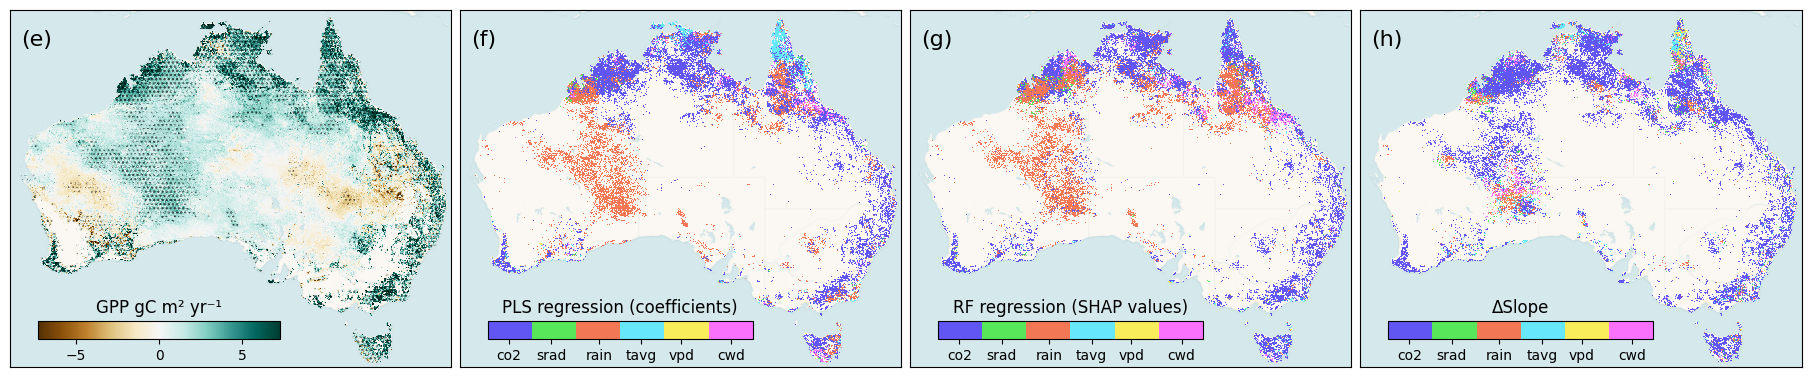

In [6]:
categories = list(p_attribution_pls.feature.values)
colours = distinctipy.get_colors(len(categories), pastel_factor=0.5, rng=2)
cmap = LinearSegmentedColormap.from_list("cwc", colours, N=len(categories))

dss = [
    '',clim_most_important_var_pls, clim_most_important_var_ml, clim_most_important_var_delta_slope,
]

names = ['','PLS regression (coefficients)', 'RF regression (SHAP values)', u'ΔSlope']
variables = ['','PLS_coefficent', 'importance','delta_slope']
cmaps = ['','plasma', 'plasma','plasma']
units = ['','PLS Coefficient', 'SHAP value',u'ΔSlope']

fig,axes=plt.subplots(1,4,figsize=(18,5),layout='constrained', sharey=True, sharex=True)

im = p_trends.slope.plot(add_colorbar=False,ax=axes[0], add_labels=False, cmap='BrBG', robust=True)

lons, lats = np.meshgrid(p_trends.longitude, p_trends.latitude)
sig_area = np.where(p_trends['p_value'] <= 0.1)
axes[0].hexbin(x=lons[sig_area].reshape(-1),
         y=lats[sig_area].reshape(-1),
         C=p_trends['slope'].where(p_trends['p_value'] <= 0.1).data[sig_area].reshape(-1),
         hatch='....',
         alpha=0,
         gridsize=(400,400)
        ) 

ctx.add_basemap(axes[0], source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)
axes[0].axes.get_xaxis().set_ticks([])
axes[0].axes.get_yaxis().set_ticks([])
axins1 = inset_axes(axes[0],width="55%",height="5%",loc="lower left", borderpad=2)
cbar = fig.colorbar(im, cax=axins1 ,orientation='horizontal')

if 'NDVI' in data_product:
    cbar.ax.set_title('fPAR yr⁻¹', fontsize=13)
else:
    cbar.ax.set_title('GPP gC m\N{SUPERSCRIPT TWO} yr⁻¹', fontsize=12)

for ds,n,vars,c,u,ax,i in zip(dss,names,variables,cmaps,units, axes.ravel(), range(len(dss))):
    if i>0:
        im = ds.plot(add_colorbar=False,ax=ax, add_labels=False, cmap=cmap)
        ctx.add_basemap(ax, source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)
        ax.axes.get_xaxis().set_ticks([])
        ax.axes.get_yaxis().set_ticks([])
        axins1 = inset_axes(ax,width="60%",height="5%",loc="lower left", borderpad=2)
        cbar = fig.colorbar(im, cax=axins1, ticks=[0.4,1.2,2.1,2.9, 3.65, 4.6],orientation='horizontal')
        cbar.ax.set_xticklabels(categories)
        cbar.ax.set_title(n, fontsize=12)

if 'NDVI' in data_product:
    letters = ['(a)','(b)','(c)','(d)']
else:
    letters = ['(e)','(f)','(g)','(h)']

for ax, l in zip(axes.ravel(), letters):
    ax.text(0.025, 0.90, l ,  transform=ax.transAxes, fontsize=16)

fig.savefig(f'/g/data/os22/chad_tmp/Aus_CO2_fertilisation/results/figs/attribution_{data_product}.png',
            bbox_inches='tight', dpi=300)

## Rank order of CO2

In [7]:
rank_co2_delta_slope = p_attribution_delta_slope['delta_slope'].rank('feature').sel(feature='co2')
rank_co2_pls = p_attribution_pls['PLS_coefficent'].rank('feature').sel(feature='co2')
rank_co2_ml = p_attribution_ml['importance'].rank('feature').sel(feature='co2')

### Plot

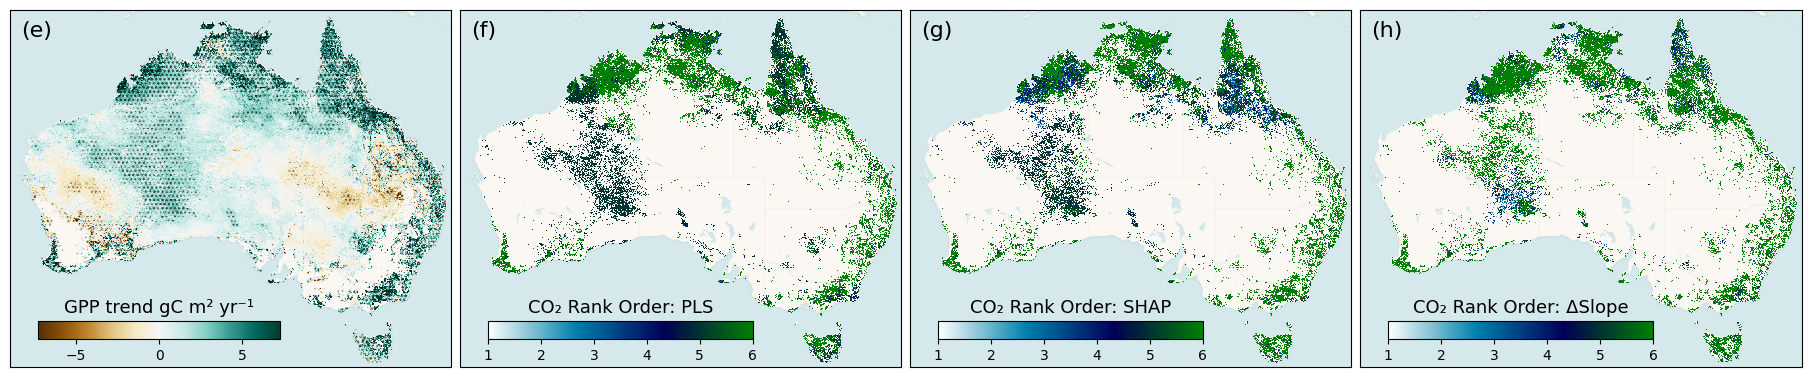

In [8]:
dss = [
    '',rank_co2_pls, rank_co2_ml, rank_co2_delta_slope
]

names = ['','PLS regression (coefficents)', 'RF regression (SHAP values)', u'ΔSlope']
variables = ['','PLS', 'SHAP','ΔSlope']
cmap = 'ocean_r'

fig,axes=plt.subplots(1,4,figsize=(18,5),layout='constrained', sharey=True)

im = p_trends.slope.plot(add_colorbar=False,ax=axes[0], add_labels=False, cmap='BrBG', robust=True)

lons, lats = np.meshgrid(p_trends.longitude, p_trends.latitude)
sig_area = np.where(p_trends['p_value'] <= 0.1)
axes[0].hexbin(x=lons[sig_area].reshape(-1),
         y=lats[sig_area].reshape(-1),
         C=p_trends['slope'].where(p_trends['p_value'] <= 0.1).data[sig_area].reshape(-1),
         hatch='....',
         alpha=0,
         gridsize=(400,400)
        ) 

ctx.add_basemap(axes[0], source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)
axes[0].axes.get_xaxis().set_ticks([])
axes[0].axes.get_yaxis().set_ticks([])

axins1 = inset_axes(axes[0],width="55%",height="5%",loc="lower left", borderpad=2)
cbar = fig.colorbar(im, cax=axins1 ,orientation='horizontal')

if 'NDVI' in data_product:
    cbar.ax.set_title('fPAR trend yr⁻¹', fontsize=13)
else:
    cbar.ax.set_title('GPP trend gC m\N{SUPERSCRIPT TWO} yr⁻¹', fontsize=13)

for ds,n,vars,ax,i in zip(dss,names,variables, axes.ravel(),range(len(dss))):
    if i>0:
        im = ds.plot(add_colorbar=False,ax=ax, add_labels=False, cmap=cmap)
        ctx.add_basemap(ax, source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)
        ax.axes.get_xaxis().set_ticks([])
        ax.axes.get_yaxis().set_ticks([])
        axins1 = inset_axes(ax,width="60%",height="5%",loc="lower left", borderpad=2)
        cbar = fig.colorbar(im, cax=axins1, ticks=range(1,7), orientation='horizontal')
        cbar.ax.set_title('CO\u2082 Rank Order: '+vars, fontsize=13)

if 'NDVI' in data_product:
    letters = ['(a)','(b)','(c)','(d)']
else:
    letters = ['(e)','(f)','(g)','(h)']

for ax, l in zip(axes.ravel(), letters):
    ax.text(0.025, 0.925, l ,  transform=ax.transAxes, fontsize=16)

fig.savefig(f'/g/data/os22/chad_tmp/Aus_CO2_fertilisation/results/figs/CO2_rank order_attribution_{data_product}.png',
            bbox_inches='tight', dpi=300)

## Agreement between modelled slope and actual slope

In [9]:
slope_difference = (p_attribution_pls.slope_actual.sel(feature='co2') -  p_attribution_pls.slope_modelled.sel(feature='co2'))
slope_difference.name = 'Difference (obs. - mod.)'
slope_difference = slope_difference.to_dataset()

ds_slopes = [p_attribution_pls.sel(feature='co2'), p_attribution_pls.sel(feature='co2'), slope_difference]
variables = ['slope_actual', 'slope_modelled', 'Difference (obs. - mod.)']
if 'NDVI' in data_product:
    names = ['Obs. fPAR yr\u207B\u00B9', 'Mod. (PLS) fPAR yr\u207B\u00B9', 'Difference (obs. - mod.)']
else:
    names = ['Obs. GPP gC m\N{SUPERSCRIPT TWO} yr⁻¹', 'Mod. (PLS) GPP gC m\N{SUPERSCRIPT TWO} yr⁻¹', 'Difference (obs. - mod.)']

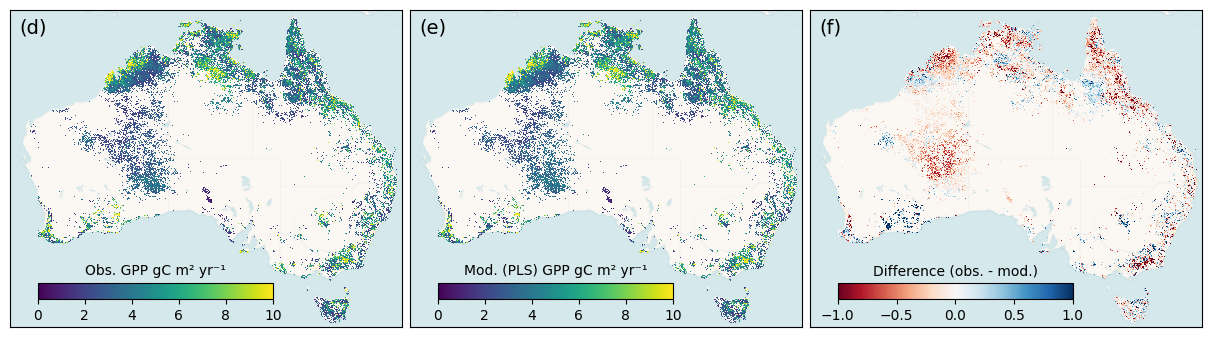

In [12]:
fig,axes=plt.subplots(1,3,figsize=(12,4),layout='constrained', sharey=True, sharex=True)

for ds,n,vars,ax in zip(ds_slopes, names, variables, axes.ravel()):
    if n=='Difference (obs. - mod.)':
        cmap = 'RdBu'
        if 'NDVI' in data_product:
            vmin, vmax=-0.004,0.004
        else:
            vmin, vmax=-1,1
    else:
        cmap='viridis'
        if 'NDVI' in data_product:
            vmin, vmax=0,0.03
        else:
             vmin, vmax=0,10
    im = ds[vars].plot(ax=ax, add_labels=False, vmin=vmin, vmax=vmax, cmap=cmap, add_colorbar=False)
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)
    # ax.set_title(n)
    axins1 = inset_axes(ax, width="60%",height="5%",loc="lower left", borderpad=2)
    if n=='Difference (obs. - mod.)':
        if 'NDVI' in data_product:
            ticks = [-0.005, 0.0, 0.005]
        else:
            ticks = [-0.5, 0, 0.5]
        cbar = fig.colorbar(im, cax=axins1, orientation='horizontal')
    else:
        cbar = fig.colorbar(im, cax=axins1,orientation='horizontal')
    cbar.ax.set_title(n, fontsize=10)

if 'NDVI' in data_product:
    letters = ['(a)','(b)','(c)']
else:
    letters = ['(d)','(e)','(f)']

for ax, l in zip(axes.ravel(), letters):
    ax.text(0.025, 0.925, l ,  transform=ax.transAxes, fontsize=14)

fig.savefig(f'/g/data/os22/chad_tmp/Aus_CO2_fertilisation/results/figs/modelled_vs_actual_slope_{data_product}.png',
            bbox_inches='tight', dpi=300)